### Závěrečný projekt - modul Python

V tomto projektu budete analyzovat data ze stránky `www.sreality.cz`. Budete tedy získávat aktuální nabídku bytů ve Zlíně.
Projekt se dělí na 2 části:
1. WebScraping - pomocí knihovny `BeautifulSoup` získejte všechny aktuální inzerce bytů v daném městě. 
- Získáte **tyto** informace: `URL odkaz bytu, rozměry bytu, dispozice bytu, cena bytu, lokace bytu (Ulice+město)`
2. Datová analýza - ETL proces
- V první fázi prověďte processing dat tak, aby obsahovala příslušné datové typy, nenulové hodnoty atp. Ulice i město bude v samostatných sloupcích.
- Zprocesovaná a vyčištěná data vyexportujte do `.csv` souboru s názvem `{vašeJméno}_zdrojová_data.csv`
3. Datová analýza - analýza dat
- Třetí část začněte tak, že si do dataframe nahrajete vámi vyexportovaný `.csv` soubor s vyscrapovanými daty.
- Ve druhé fázi proveďte analýzu dat a odpovězte na tyto dotazy:
- `Jaká je průměrná cena bytů?`
- `Jaká je průměrná cena bytů pro každou dispozice (1+1, 2+1, atp.)? Zobrazte i na grafu.`
- `Jaká je průměrná velikost bytu pro každou dispozice?`
- `Existuje ulice, kde je vyšší koncentrace dražších bytů?`
- `Jaký typ dispozice je v daném městě nejčastěji inzerovan? Který to je? Proč myslíte, že tomu tak je?`
- `Existují zde inzerce bytů, které stojí více, než 20.000,-? Pokud ano, jsou v této cenové hladině inzerovány i maximálně dvoupokojové byty (2+1/2+kk)?`
- `Zjištěte minimální a maximální inzerce pro každou dispozici bytu. Která dispozice má největší rozptyl mezi minimální a maximální inzerovanou cenou?`


Dotazy zodpovězte ve vašem pracovním notebooku a výsledný soubor nahrajte na GitHub.


### WebScraping

In [ ]:
from bs4 import BeautifulSoup
import requests
from pprint import pprint
import matplotlib.pyplot as plt

strana = 1
zoznamBytov = []

while True:
    print(f'Prechádzam stránku číslo {strana}')
    response = requests.get(f'https://www.sreality.cz/hledani/pronajem/byty/zlin?strana={strana}').text
    soup = BeautifulSoup(response, 'html.parser')

    vsetkyByty = soup.find_all(name='li', class_='MuiGrid2-root')

    for byt in vsetkyByty:
        # ošetrenie inzercie - Ďakujem :D 
        try:
            castUrlBytu = byt.find(name='a', class_='MuiTypography-root')['href']
            celaUrlBytu = 'https://www.sreality.cz' + castUrlBytu

            # najskôr si vytiahnem všetky P elementy s konkretnou class a následne ich podľa indexu rozdelím
            nazovLokalita = byt.find_all(name='p', class_='css-d7upve')
            nazovBytu = nazovLokalita[0].text.strip()
            lokalitaBytu = nazovLokalita[1].text.strip()

            cena = byt.find(name='p', class_='css-ca9wwd').text.strip().replace('\xa0', '').replace('Kč/měsíc', '').replace('Kč', '')

        # v prípade chyby vypíšem hlášku a pokrečujem
        except Exception as e:
            print("Inzercia! Preskakujem a pokračujem")
            continue
        
        # tvorba jedného záznamu
        jedenZaznam = {
            'Url_inzercie': celaUrlBytu,
            'Nazov_inzercie': nazovBytu,
            'Lokalita': lokalitaBytu,
            'Cena': cena
        }

        # append záznamu do zoznamu
        zoznamBytov.append(jedenZaznam)

    # hľadanie buttonu s text obsahom Další stránka
    buttonNext = soup.find(name='div', class_='css-1wzyqky').text

    # kontrola výskytu buttonu
    if buttonNext != 'Další stránka':
        # v prípade že sa nevyskytuje, končíme
        print('Končím scrapping')
        break
    else:
        strana += 1

### Datová analýza

In [5]:
import pandas as pd

df = pd.DataFrame(zoznamBytov)

# odfiltrovanie ceny: cena na vyžiadanie
df_final = df.loc[ df['Cena'] != 'Cena na vyžádání' ].copy()

# pretypovanie ceny na float
df_final['Cena'] = df_final['Cena'].astype(float)

# vytiahnutie dispozície + rozlohy do samostatných stĺpcov
# s týmto som mal veľký problém tu mi musel pomôcť až chat
df_final[['Dispozicia', 'Rozloha']] = df_final['Nazov_inzercie'].str.extract(r'(?:bytu\s)?(?P<Dispozicia>\d\+?\d?k?k?|pokoje|atypický)\D+?(?P<Rozloha>\d+\s?m²?)')

# prepísanie hodnoty v dispozícií
df_final['Dispozicia'] = df_final['Dispozicia'].replace({'pokoje': '1 pokoj'})

# pretypovanie rozlohy na int
# tak isto mi musel pomôcť chat
df_final['Rozloha'] = df_final['Rozloha'].str.extract(r'(\d+)').astype(int)

# oddelenie ulice pomocou čiarky
df_final['Ulica'] = df_final['Lokalita'].str.split(',').str[0]

# export do CSV - JE TO ALE BEZ BYTOV kde je typ ceny: cena na vyžiadanie
# boli to iba 2 záznamy
df_final.to_csv('TadeasGalbavy_zdrojová_data.csv', sep=';', encoding='UTF-8', index=False)

In [6]:
df_byty = pd.read_csv('TadeasGalbavy_zdrojová_data.csv', sep=';', encoding='UTF-8')
df_byty.columns

Index(['Url_inzercie', 'Nazov_inzercie', 'Lokalita', 'Cena', 'Dispozicia',
       'Rozloha', 'Ulica'],
      dtype='object')

- `Jaká je průměrná cena bytů?`

In [8]:
round(df_byty['Cena'].mean(), 2)

np.float64(13155.51)

- `Jaká je průměrná cena bytů pro každou dispozice (1+1, 2+1, atp.)? Zobrazte i na grafu.`

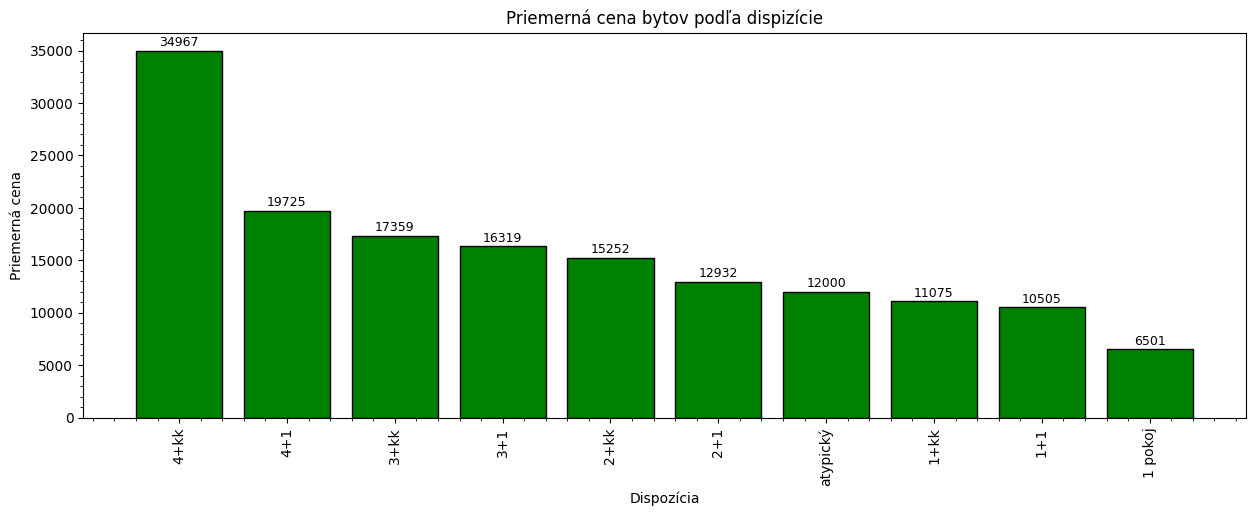

In [ ]:
(df_byty.groupby('Dispozicia')['Cena']
    .agg(['mean', 'max', 'min', 'median'])
    .sort_values(by='mean', ascending=False)
    .round(2)
)

df_graf = (df_byty.groupby('Dispozicia')['Cena']
                .mean()
                .round(2)
                .reset_index()
                .sort_values(by='Cena', ascending=False)
                
            )

plt.figure(figsize=(15,5))
 

plt.bar(df_graf['Dispozicia'], df_graf['Cena'], color='green', edgecolor='black')

for i, v in enumerate(df_graf['Cena']):
    plt.text(i, v + 200, f'{v:.0f}', ha='center', va='bottom', fontsize=9)

plt.xticks(df_graf['Dispozicia'], rotation=90)
plt.title('Priemerná cena bytov podľa dispizície')
plt.ylabel('Priemerná cena')
plt.xlabel('Dispozícia')
plt.minorticks_on()

plt.savefig('Priemerná cena bytov podľa dispizície.png', dpi=300, bbox_inches='tight', transparent=True) 

plt.show()

In [43]:
(df_byty.groupby('Dispozicia')['Cena']
                .mean()
                .round(2)
                .reset_index()
                .sort_values(by='Cena', ascending=False)
            )

,Dispozicia,Cena
8,4+kk,34966.67
7,4+1,19725.00
6,3+kk,17193.75
5,3+1,16318.57
4,2+kk,15387.08
3,2+1,12933.75
9,atypický,12000.00
2,1+kk,11043.23
1,1+1,10505.13
0,1 pokoj,6500.73


- `Jaká je průměrná velikost bytu pro každou dispozice?`

In [45]:
(df_byty.groupby('Dispozicia')['Rozloha']
    .mean()
    .round(2)
    .reset_index(name='priemerna rozloha')
    .sort_values(by='priemerna rozloha', ascending=False)
)

,Dispozicia,priemerna rozloha
8,4+kk,120.00
7,4+1,84.50
5,3+1,71.81
6,3+kk,68.06
9,atypický,59.00
3,2+1,57.95
4,2+kk,51.17
0,1 pokoj,42.09
1,1+1,35.17
2,1+kk,29.85


- `Existuje ulice, kde je vyšší koncentrace dražších bytů?`

In [ ]:
# priradenie príznaku či je cena nadpriemerná (True) alebo podpriemerná (False)
df_byty['Uroven_ceny'] = df_byty['Cena'].apply(
    lambda x: True if x > df_byty['Cena'].mean() else False
)

df_drahe = df_byty.loc[ df_byty['Uroven_ceny'] ]

df_drahe.groupby('Ulica')['Uroven_ceny'].count().reset_index().nlargest(columns='Uroven_ceny', n=5)


,Ulica,Uroven_ceny
64,Štefánikova,4
19,Komenského,3
20,Kvítková,3
25,Moravní,3
37,Pasecká,3


- `Jaký typ dispozice je v daném městě nejčastěji inzerovan? Který to je? Proč myslíte, že tomu tak je?`

In [48]:
df_byty['Dispozicia'].value_counts()
df_byty.groupby('Dispozicia')['Cena'].count().reset_index(name='Pocet inzercii').nlargest(columns='Pocet inzercii', n=5)

,Dispozicia,Pocet inzercii
2,1+kk,62
3,2+1,40
4,2+kk,24
1,1+1,23
5,3+1,21


In [50]:
df_byty.groupby('Dispozicia')['Cena'].mean().reset_index(name='Pocet inzercii').nsmallest(columns='Pocet inzercii', n=5)

,Dispozicia,Pocet inzercii
0,1 pokoj,6500.727273
1,1+1,10505.130435
2,1+kk,11043.225806
9,atypický,12000.000000
3,2+1,12933.750000


In [54]:
df_byty.groupby('Dispozicia')['Rozloha'].agg(['min', 'max', 'mean']).reset_index()

,Dispozicia,min,max,mean
0,1 pokoj,20,114,42.090909
1,1+1,18,49,35.173913
2,1+kk,20,45,29.854839
3,2+1,35,80,57.950000
4,2+kk,34,80,51.166667
5,3+1,52,110,71.809524
6,3+kk,12,98,68.062500
7,4+1,75,98,84.500000
8,4+kk,100,147,120.000000
9,atypický,25,93,59.000000


In [55]:
df_byty['Rozloha'].mean()

np.float64(48.94174757281554)

In [75]:
df_calc = df_byty.groupby('Dispozicia').agg(
    priemer_rozloha = ('Rozloha', 'mean'),
    priemer_cena = ('Cena', 'mean')
).reset_index().round(2)

df_calc['pomer'] = (df_calc['priemer_cena'] / df_calc['priemer_rozloha']).round(2)
df_calc.nlargest(columns='pomer', n=3)

,Dispozicia,priemer_rozloha,priemer_cena,pomer
2,1+kk,29.85,11043.23,369.96
4,2+kk,51.17,15387.08,300.71
1,1+1,35.17,10505.13,298.70


- `Existují zde inzerce bytů, které stojí více, než 20.000,-? Pokud ano, jsou v této cenové hladině inzerovány i maximálně dvoupokojové byty (2+1/2+kk)?`

In [74]:
df_nad_20k = df_byty.loc[ df_byty['Cena'] > 20000]

df_nad_20k_vystup = df_nad_20k.loc[ (df_nad_20k['Dispozicia'] == '2+1') | (df_nad_20k['Dispozicia'] == '2+kk') ]

df_nad_20k_vystup[['Url_inzercie', 'Lokalita', 'Cena', 'Dispozicia']].to_csv('vystup.csv', sep=';', encoding='CP1250', index=False)
df_nad_20k_vystup[['Url_inzercie', 'Lokalita', 'Cena', 'Dispozicia']]

,Url_inzercie,Lokalita,Cena,Dispozicia
42,https://www.sreality.cz/detail/pronajem/byt/2+...,"Moravní, Otrokovice",20990.0,2+kk
103,https://www.sreality.cz/detail/pronajem/byt/2+...,"Partyzánská, Zlín",23500.0,2+kk
150,https://www.sreality.cz/detail/pronajem/byt/2+...,"Štefánikova, Zlín",23900.0,2+kk


- `Zjištěte minimální a maximální inzerce pro každou dispozici bytu. Která dispozice má největší rozptyl mezi minimální a maximální inzerovanou cenou?`

In [34]:
df_rozlohy = df_byty.groupby('Dispozicia').agg(
    min_cena = ('Cena', 'min'),
    max_cena = ('Cena', 'max')
)

df_rozlohy['Rozdiel_ceny'] = df_rozlohy['max_cena'] - df_rozlohy['min_cena']

df_rozlohy.reset_index().nlargest(columns='Rozdiel_ceny', n=1)

,Dispozicia,min_cena,max_cena,Rozdiel_ceny
6,3+kk,6000.0,36000.0,30000.0
